## Computer Vision on Public Lands Webcams

#### Date: 9/25/25
#### Author: Eric Englin

Goal: The goal of this notebook is to create a YOLOv11 method to track parking lot utilization over time. It is meant to be run locally while finetuning a method that can eventually be scaled for longer-term monitoring and data collection. 

In [1]:
#import libraries
import os
import time
from datetime import datetime, timezone
import pandas as pd

import cv2
import yt_dlp
from ultralytics import YOLO
from collections import defaultdict
import supervision as sv
from bs4 import BeautifulSoup
import requests
from IPython.display import display, Image
from PIL import Image as Img
from PIL import ImageTk


#### Download stream snapshot from webcam URL

In [ ]:
# note: this link changes (daily?). Go to https://www.ipcamlive.com/willowcreektrail, inspect element, and search 
# for the word "snapshot" to get the latest link. We could code a step here that pulls the component content systematically
snapshot_url = "https://s94.ipcamlive.com/streams/5edlevt9dpm5onzzk/snapshot.jpg"

# defining user agent as I attempt to increase the image quality retrieved with the requests.get call. don't think it's changing anything really
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.0.0 Safari/537.36"}

In [3]:
def get_stream_jpg(snapshot_url):
    response = requests.get(snapshot_url, headers=headers)
    
    #Nineveh question: what is/why is this -3 thing here?
    ts = datetime.now(timezone.utc).strftime("%Y%m%d_%H%M%S_%f")[:-3]
    
    img_name = 'image/snapshot' + ts + ".jpg"
    
    with open(img_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    return img_name

In [4]:
img_name = get_stream_jpg(snapshot_url)
# display inline
display(Image(filename=img_name))

## YOLO testing

#### YOLO testing to predict cars, trucks, and buses

In [5]:
# Load the YOLO model
model = YOLO('yolo11l.pt')

class_list = model.names 

# Dictionary to store object counts by class
class_counts = defaultdict(int)

results = model.predict(source = img_name, classes = [2,3,5,7]) 
# results[0] contains detections for the first image
res = results[0]

# res.boxes.cls are class indices (tensor). Convert to numpy.
if hasattr(res, "boxes") and len(res.boxes) > 0:
    class_ids = res.boxes.cls.cpu().numpy().astype(int)  # e.g., [2, 0, 2, ...]
    confidences = res.boxes.conf.cpu().numpy()
else:
    class_ids = np.array([], dtype=int)
    confidences = np.array([])

# COCO class id for "car" is 2
CAR_CLASS_ID = 2
car_mask = (class_ids == CAR_CLASS_ID)
num_cars = int(car_mask.sum())

print(f"Detected cars: {num_cars}")

# Optionally, print each car bbox and confidence
if num_cars > 0:
    boxes = res.boxes.xyxy.cpu().numpy()  # x1,y1,x2,y2
    car_boxes = boxes[car_mask]
    car_confs = confidences[car_mask]
    for i, (box, conf) in enumerate(zip(car_boxes, car_confs), start=1):
        x1, y1, x2, y2 = box
        print(f"Car {i}: bbox=({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}), conf={conf:.2f}")

# Optional: show annotated image inline (Jupyter)
# This will save an annotated image to 'runs/detect/predict' by default. You can also render manually:
annotated = res.plot()  # returns an np.ndarray image with boxes drawn
display(Img.fromarray(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)))


WARNING Image Read Error c:\Users\Nineveh.OConnell\OneDrive - DOT OST\Documents\code\Public-Lands-Computer-Vision\Willow Creek Trail\image\snapshot20250926_210149_358.jpg


ValueError: need at least one array to stack

#### YOLO testing to track cars, trucks, and buses

requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 13.5 MB/s  0:00:00

requirements: AutoUpdate success  3.5s
WARNING requirements: Restart runtime or rerun command for updates to take effect


image 1/1 c:\Users\Nineveh.OConnell\OneDrive - DOT OST\Documents\code\Public-Lands-Computer-Vision\Willow Creek Trail\image\snapshot20250926_191311_412.jpg: 480x640 11 cars, 3 trucks, 737.4ms
Speed: 2.4ms preprocess, 737.4ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)
Detected cars: 11
Car 1: bbox=(196.4, 276.5, 247.9, 308.4)
Car 2: bbox=(369.3, 277.0, 427.8, 314.0)
Car 3: bbox=(278.7, 276.8, 339.7, 311.8)
Car 4: bbox=(159.3, 278.0, 200.6, 308.0)
Car 5: bbox=(67.5, 272.3, 118.4, 298.8)
Car 6: bbox=(558.3, 270.8, 598.6, 314.2)
Car 7: bbox=(6.0, 277.5, 37.5, 297.3)
Car 8: bbox=(428.1, 272.5, 478.1, 314.0)
Car 9: bbox

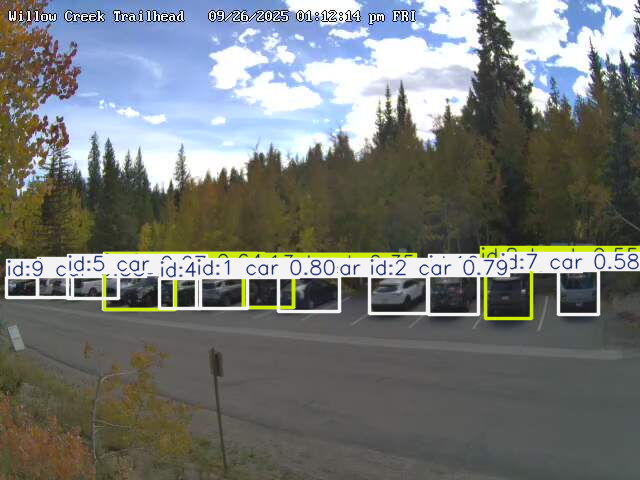

In [ ]:
# Load the YOLO model
model = YOLO('yolo11l.pt')

class_list = model.names 

# Dictionary to store object counts by class
class_counts = defaultdict(int)

results = model.track(source = img_name, classes = [2,3,5,7], persist=True) 

# results[0] contains detections for the first image
res = results[0]

# res.boxes.cls are class indices (tensor). Convert to numpy.
if hasattr(res, "boxes") and len(res.boxes) > 0:
    class_ids = res.boxes.cls.cpu().numpy().astype(int)  # e.g., [2, 0, 2, ...]
    confidences = res.boxes.conf.cpu().numpy()
else:
    class_ids = np.array([], dtype=int)
    confidences = np.array([])

# COCO class id for "car" is 2
CAR_CLASS_ID = 2
car_mask = (class_ids == CAR_CLASS_ID)
num_cars = int(car_mask.sum())

print(f"Detected cars: {num_cars}")

# Optionally, print each car bbox and confidence
boxes = res.boxes.xyxy.cpu().numpy()  # x1,y1,x2,y2
car_boxes = boxes[car_mask]
for i, box in enumerate(car_boxes, start=1):
    x1, y1, x2, y2 = box
    print(f"Car {i}: bbox=({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f})")

# Optional: show annotated image inline (Jupyter)
# This will save an annotated image to 'runs/detect/predict' by default. You can also render manually:
annotated = res.plot()  # returns an np.ndarray image with boxes drawn
display(Img.fromarray(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)))

## YOLO function testing

If all the above chunks work, you should now be set up to run the code continuously with vehicle tracking.
- YOLO testing to track cars, trucks, and buses
- Make better looking boxes around vehicles
- Continuously run the model
- Create a dataset of the parking lot capacity over time

In [ ]:
# Load the YOLO model
model = YOLO('yolo11l.pt')

class_list = model.names 

# Dictionary to store object counts by class
class_counts = defaultdict(int)

def capture_frames(snapshot_url):
    
    resultsList = []
    counter = 0


    while True: 

        img_name = get_stream_jpg(snapshot_url)
    
        # Run YOLO tracking on the frame
        results = model.track(source = img_name, classes = [2,3,5,7], persist = True) 
    
    
        # results[0] contains detections for the first image
        res = results[0]
        frame = res.orig_img
        
        
        # prep timestamp for file name
        current_datetime = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
        
        # Ensure results are not empty
        if results[0].boxes.data is not None:
            # Get the detected boxes, their class indices, and track IDs
            boxes = results[0].boxes.xyxy.cpu()
            track_ids = results[0].boxes.id.int().cpu().tolist()
            class_indices = results[0].boxes.cls.int().cpu().tolist()
            confidences = results[0].boxes.conf.cpu()
                
            # Loop through each detected object
            for box, track_id, class_idx, conf in zip(boxes, track_ids, class_indices, confidences):
                x1, y1, x2, y2 = map(int, box)
                cx = (x1 + x2) // 2  # Calculate the center point
                cy = (y1 + y2) // 2            
        
                class_name = class_list[class_idx]
        
                cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
                
                cv2.putText(frame, f"ID: {track_id} {class_name}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2) 
        
                dfKeyFeatures = pd.DataFrame({'id' : [track_id], 
                                              'class' : [class_name], 
                                              'confidence' : [conf], 
                                              'cx' : [cx], 
                                              'cy' : [cy], 
                                              'timestamp' : [current_datetime]})
                resultsList.append(dfKeyFeatures)
        
            # Display the counts on the frame
            y_offset = 50
            for class_name, count in class_counts.items():
                cv2.putText(frame, f"{class_name}: {count}", (50, y_offset),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
                y_offset += 30
        
        ### Save frame    
        # Save as PNG
        # YOUR FILE PATH HERE
        filename ='annotated_image'
        cv2.imwrite(f"{filename}/frame_{str(current_datetime)}.png", frame)
        print(f"Saved frame {current_datetime}", "; detected ", len(res.boxes.cls.cpu().numpy().astype(int)), " cars and trucks")
        time.sleep(15)
        counter += 1

        if counter > 10:
            break

    combined_df = pd.concat(resultsList)
    ts_for_export = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
    # YOUR FILE PATH HERE
    datafolder =r'C:\Users\Nineveh.OConnell\OneDrive - DOT OST\volpe-portfolio-PublicLands - AI Real-Time Parking Project\Data'
    combined_df.to_csv(f"{datafolder}/data_download_export_{str(ts_for_export)}.csv", index=False) 

In [ ]:
if __name__ == "__main__":
    print("Stream URL:", snapshot_url)
    capture_frames(snapshot_url)


Stream URL: https://s94.ipcamlive.com/streams/5e2mwp7nk8hohvobq/snapshot.jpg

image 1/1 c:\Users\Nineveh.OConnell\OneDrive - DOT OST\Documents\code\Public-Lands-Computer-Vision\Willow Creek Trail\image\snapshot20250926_192444_807.jpg: 480x640 12 cars, 2 trucks, 840.4ms
Speed: 2.6ms preprocess, 840.4ms inference, 4.9ms postprocess per image at shape (1, 3, 480, 640)
Saved frame 2025-09-26 15-24-45 ; detected  14  cars and trucks

image 1/1 c:\Users\Nineveh.OConnell\OneDrive - DOT OST\Documents\code\Public-Lands-Computer-Vision\Willow Creek Trail\image\snapshot20250926_192501_246.jpg: 480x640 12 cars, 2 trucks, 549.4ms
Speed: 3.3ms preprocess, 549.4ms inference, 7.2ms postprocess per image at shape (1, 3, 480, 640)
Saved frame 2025-09-26 15-25-01 ; detected  14  cars and trucks

image 1/1 c:\Users\Nineveh.OConnell\OneDrive - DOT OST\Documents\code\Public-Lands-Computer-Vision\Willow Creek Trail\image\snapshot20250926_192517_201.jpg: 480x640 12 cars, 2 trucks, 581.3ms
Speed: 1.7ms preproc